## Level Up

In our module3_project jupyter notebook we discussed how we approached this dataset and explore the different classification models as a beginner, this means we dived into the basics of how to use each individual model. In this notebook we will discuss how we can compare models and optimize them. We will be using the same dataset as in module3_project notebook. Please refer to module3_project or the readme file for information on the variables of this dataset.  

In [4]:
import numpy as np
import pandas as pd 


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score,\
precision_score, recall_score, roc_auc_score

from sklearn.metrics import precision_recall_curve

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [33]:
df = pd.read_csv('hearts.csv')

We follow the same first steps to clean/modify our data:
1. switch 0,1 for target
2. handle categorical values
3. drop duplicates
4. drop outliers
5. correct range

In [35]:
def switch(value):
    if value == 0:
        return True
    elif value == 1:
        return False
df.target = df.target.apply(lambda x: switch(x))

In [36]:
df['thal'] = df['thal'].replace(0, 'No description')
df['thal'] = df['thal'].replace(1, 'fixed defect')
df['thal'] = df['thal'].replace(2, 'normal')
df['thal'] = df['thal'].replace(3, 'reversable defect')
df['cp'] = df['cp'].replace(0, 'asymptomatic')
df['cp'] = df['cp'].replace(1, 'atypical angina')
df['cp'] = df['cp'].replace(2, 'non-anginal pain')
df['cp'] = df['cp'].replace(3, 'typical angina')
df['restecg'] = df['restecg'].replace(0, 'ventricular hypertrophy')
df['restecg'] = df['restecg'].replace(1, 'normal')
df['restecg'] = df['restecg'].replace(2, 'ST-T wave abnormality')
df['slope'] = df['slope'].replace(0, 'downsloping')
df['slope'] = df['slope'].replace(1, 'flat')
df['slope'] = df['slope'].replace(2, 'upsloping')

In [13]:
temp = pd.get_dummies(df[['cp', 'restecg', 'slope', 'thal']])
df = df.join(temp, how='left')
df = df.drop(columns = ['cp','restecg', 'slope', 'thal'], axis=1)

In [14]:
df = df.drop(['thal_0'], axis=1)

In [18]:
df = df.drop_duplicates()

In [8]:
df = df[df['trestbps'] < 180]
df = df[df['oldpeak'] < 5]
df = df[df['chol'] < 450]
df = df[df['thalach'] > 80]

In [9]:
def add_fractional_part(value):
    x = np.random.uniform(0,1)
    return round(value + x, 2)

In [10]:
df.age = df.age.apply(lambda x: add_fractional_part(x))

In [11]:
df.age = ( df.age - df.age.min() ) / ( df.age.max() - df.age.min() )
df.thalach = ( df.thalach - df.thalach.min() ) / ( df.thalach.max() - df.thalach.min())
df.trestbps = ( df.trestbps - df.trestbps.min() ) / ( df.trestbps.max() - df.trestbps.min())
df.oldpeak = ( df.oldpeak - df.oldpeak.min() ) / ( df.oldpeak.max() - df.oldpeak.min() )
df.chol = ( df.chol - df.chol.min() ) / ( df.chol.max() - df.chol.min())


## Comparing Models
We will be comparing several different models and looking for the best threshold for each. 
<br>Note: We have optimized thresholds and tunes out models according to accuracy for general purposes. However we can easily modify the code so that our models are optimized for recall.  

In [45]:
import mystats as ms

In [13]:
X_train, X_test, y_train, y_test = ms.split(df, 'target', .25)

In [122]:
def threshold_optimizer_accuracy(X_train, y_train, X_test, y_test, cls):
    '''
    parameters: X_train, y_train, X_test, y_test <arrays> dataset, cls <classifier>
    returns: best threshold in accordance with accuracy
    '''
    test_accuracy_score = []
    for t in np.arange(0,1,0.1):
        y_hat_test = (cls.fit(X_train,y_train).predict_proba(X_test)[:,1] >= t).astype(bool)
        test_accuracy_score.append((accuracy_score(y_test, y_hat_test),t))
    
    # get max accuracy score
    maximum = max([x[0] for x in test_accuracy_score])
    for x in test_accuracy_score:
        if x[0] == maximum:
            return x
            

In [64]:
# Instantiate the classfiers and make a list
SEED = 0
classifiers = [LogisticRegression(random_state=SEED), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(random_state=SEED),
               RandomForestClassifier(random_state=SEED),
               AdaBoostClassifier(random_state = SEED),
               GradientBoostingClassifier(random_state = SEED),
               xgb.XGBClassifier(),
               GaussianNB(),
               SVC(random_state = SEED, probability = True)]


def roc_mult_models(X_train, y_train, X_test, y_test, classifiers_list):
    '''
    parameters: X_train, y_train, X_test, y_test <arrays> dataset, classifiers_list <list> of classifiers
    returns: roc graph for each model
    '''
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for cls in classifiers_list:
        model = cls.fit(X_train, y_train)
        y_hat_test = model.predict_proba(X_test)[:,1]
    
        fpr, tpr, _ = roc_curve(y_test,  y_hat_test)
        auc = roc_auc_score(y_test, y_hat_test)
    
        result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)
    
    fig = plt.figure(figsize=(10,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()
    

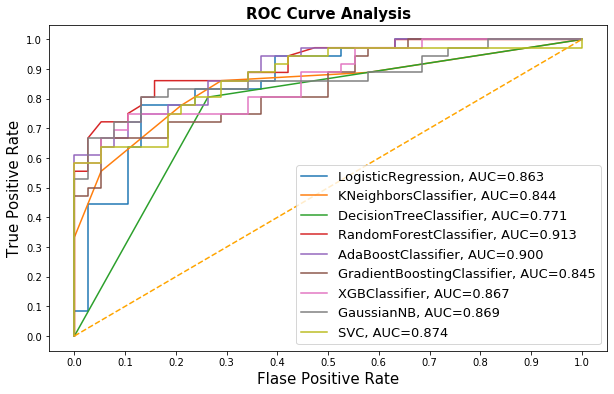

In [150]:
roc_mult_models(X_train, y_train, X_test, y_test, classifiers)

In [80]:
#run twice to drop the last two classifiers in our classifers list
classifiers.pop()

GaussianNB()

In [93]:
#Make a dictionary of parameter grids
parameters ={
    'LR_params' : {
    'solver': ['liblinear'],
    'C': [0.1, 1],
    },
    'KNN_params' : {
    'n_neighbors': range(7,12),
    'weights': ['uniform', 'distance'],
    'p': [1, 5]
    },
    'DT_params' : {
    'max_features': range(2,7),
    'max_depth': range(2,10),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [.2, .3, .4],
    },
    'RF_params' : {
    'max_depth': range(1,15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [3,4,6]
    },
    'AB_params' : {
    'n_estimators' : [20, 50, 100, 200],
    'learning_rate' : [0.5, 1, 1.5]
    },
    'GB_params' : {
    'learning_rate' : [0.1, 0.15, 0.2],    
    'n_estimators' : [20, 50, 100, 200],
    'max_depth' : [3, 5, 10, 15],
    'min_samples_split' : [2, 3, 5]
    },
    'XGB_params' : {
    'n_estimators': [20, 50, 100,200],
    'max_depth': [3, 5, 10, 20],
    'min_child_weight': [2, 3, 5]
    }
}

Since we have many parameters we don't want to use GridSearchCV since this goes through every possible permutation of parameters in our grid. The number of all possible permutations can add up very quickly, therefore GridSearchCV can be both time consuming and will burn my laptop. 

In [94]:
list_param_grids = parameters.values()
best_params_accuracy = []
for cls, param in zip(classifiers, list_param_grids):
    grid_search = RandomizedSearchCV(estimator = cls, param_distributions = param, cv = 10, scoring='accuracy')
    grid_search.fit(X_train, y_train);
    grid_search.best_params_
    best_grid = grid_search.best_estimator_
    best_params_accuracy.append(best_grid)

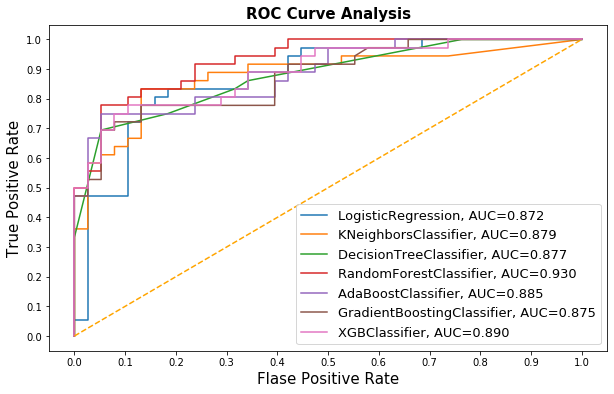

In [95]:
roc_mult_models(X_train, y_train, X_test, y_test, best_params_accuracy)

In [144]:
classifiers_list = ['Logistic regression',
                   'KNN',
                   'Decisiont Tree',
                   'Random Forest',
                   'AdaBoost',
                   'GradientBoost',
                   'XGBoost']

In [134]:
thresholds = [threshold_optimizer_accuracy(X_train, y_train, X_test, y_test, cls) for cls in best_params_accuracy]
for model, t in zip(classifiers_list, thresholds):
    print(f'For {model}, the best threshold was {t[1]} with accuracy score {round(t[0]*100,2)} %')

For Logistic regression, the best threshold was 0.5 with accuracy score 82.43 %
For KNN, the best threshold was 0.4 with accuracy score 85.14 %
For Decisiont Tree, the best threshold was 0.5 with accuracy score 78.38 %
For Random Forest, the best threshold was 0.5 with accuracy score 83.78 %
For AdaBoost, the best threshold was 0.5 with accuracy score 83.78 %
For GradientBoost, the best threshold was 0.6000000000000001 with accuracy score 82.43 %
For XGBoost, the best threshold was 0.5 with accuracy score 83.78 %


In [138]:
other_classifiers={'Gaussian Naive Bayes': GaussianNB(),
                   'Support Vector Classifier': SVC(random_state = SEED, probability = True)}
thresholds = [threshold_optimizer_accuracy(X_train, y_train, X_test, y_test, cls) for cls in other_classifiers.values()]
for model, t in zip(other_classifiers.keys(), thresholds):
    print(f'For {model}, the best threshold was {round(t[1],2)} with accuracy score {round(t[0]*100,2)} %')

For Gaussian Naive Bayes, the best threshold was 0.7 with accuracy score 83.78 %
For Support Vector Classifier, the best threshold was 0.4 with accuracy score 78.38 %


## Precision v. Recall
As we have seen how to optimize for one specific score in the previous section (such as accuracy) we dive in to see how our models can perform while optimizing on recall and accuracy. Usually prcision and recall are at the expense of one another. What we will do in this section is try to optimize recall but not at the expense of accuracy. 

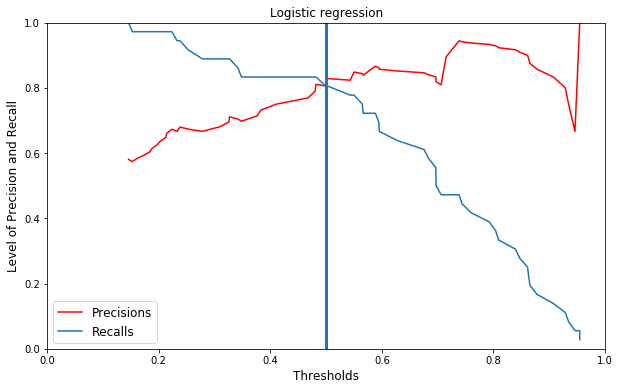

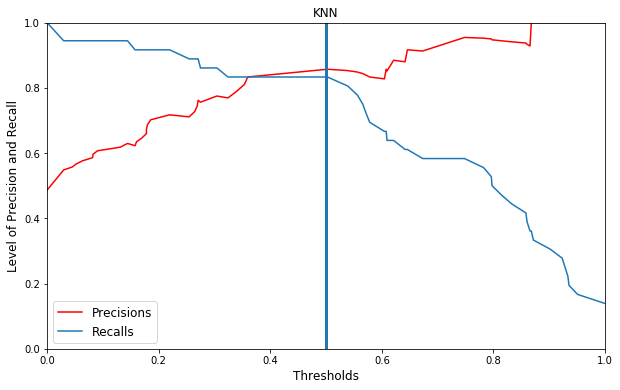

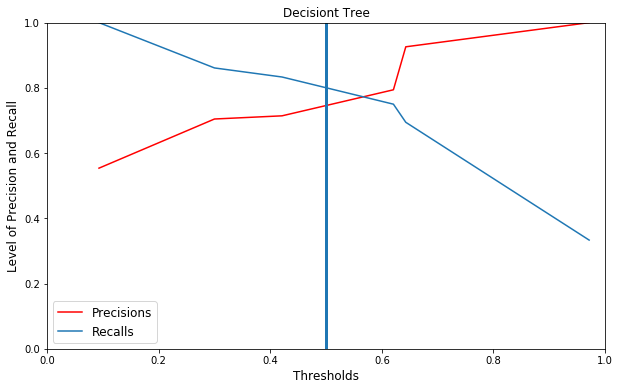

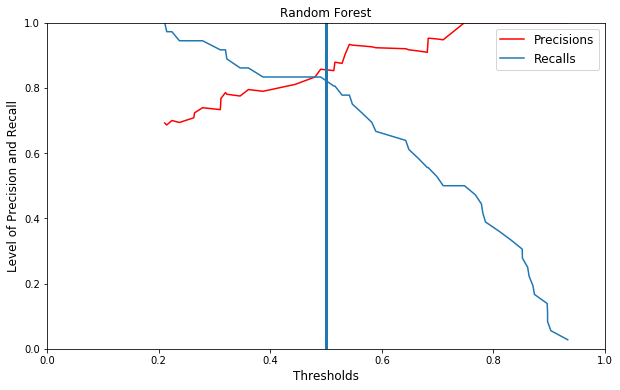

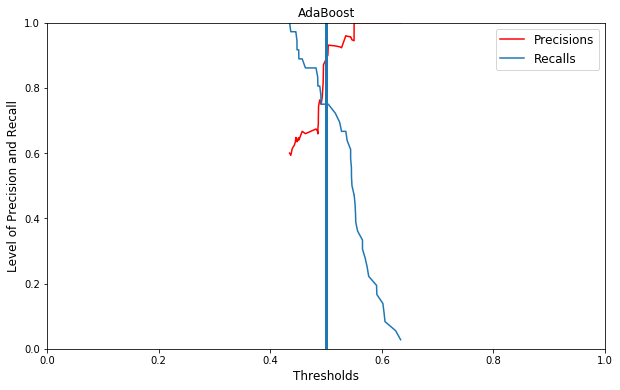

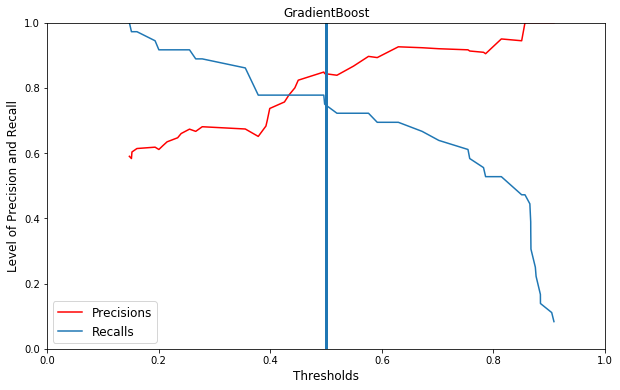

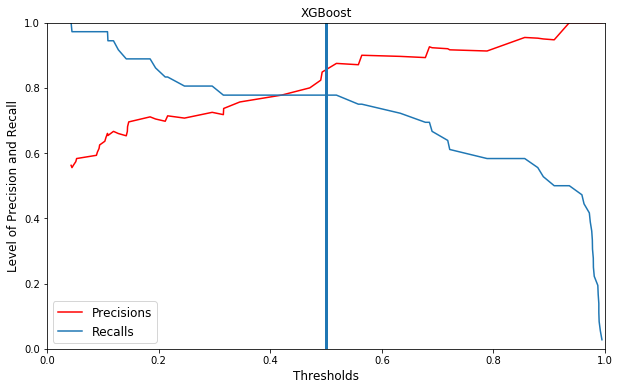

In [148]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(thresholds, precisions[:-1], 'r', label='Precisions')
    plt.plot(thresholds, recalls[:-1], label='Recalls')
    plt.ylabel('Level of Precision and Recall', fontsize=12)
    plt.title('Precision and Recall Scores as a function of the decision threshold', fontsize=12)
    plt.xlabel('Thresholds', fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.axvline(x=0.5, linewidth=3)

for cls, name in zip(best_params_accuracy, classifiers_list):
    model = cls.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:,1]
    
    prec, rec, tre = precision_recall_curve(y_test, y_proba)
    
    plot_prec_recall_vs_tresh(prec, rec, tre)
    plt.title(name)
    plt.show()
    

In [199]:
def threshold_optimizer(X_train, y_train, X_test, y_test, cls, score , min_acc_score = .8):
    '''
    parameters: X_train, y_train, X_test, y_test <arrays> dataset, 
                cls <classifier>,
                score <string> recall, precision or f1
                min_acc_score <float> minimal accuracy score desired, default is .80
                
    returns: best threshold in accordance with accuracy and chosen score
    '''

    test_score = []
    for t in np.arange(0,1,0.1):
        y_hat_test = (cls.fit(X_train,y_train).predict_proba(X_test)[:,1] >= t).astype(bool)
        if score == 'recall':
            test_score.append((accuracy_score(y_test, y_hat_test), recall_score(y_test, y_hat_test),t))
        elif score == 'precision':
            test_score.append((accuracy_score(y_test, y_hat_test), precision_score(y_test, y_hat_test),t))
        elif score == 'f1':
            test_score.append((accuracy_score(y_test, y_hat_test), f1_score(y_test, y_hat_test),t))
    
    #get max score
    max_score = max([x[1] for x in test_score if x[0] >= min_acc_score])
    for x in test_score:
        if x[1] == max_score:
            return x        


Remember in our module3_project notebook, we had said for our particular data we wanted a good recall score but not at a high cost of our accuracy score. So we are going to look for a threshold with the best recall score amongst the minimum accuracy score of 78%, we chose 78 because our decision tree and support vector classifier had performed optimal at 78% accuracy.   

In [203]:
score = 'recall'
thresholds = [threshold_optimizer(X_train, y_train, X_test, y_test, cls, score, .78) for cls in best_params_accuracy]
for model, t in zip(classifiers_list, thresholds):
    print(f'For {model}:')
    print(f'the best threshold was {t[2]}')
    print(f'with accuracy score {round(t[0]*100,2)} % and the {score} metric: {round(t[1]*100,2)} %')

For Logistic regression:
the best threshold was 0.4
with accuracy score 78.38 % and the recall metric: 83.33
For KNN:
the best threshold was 0.2
with accuracy score 78.38 % and the recall metric: 91.67
For Decisiont Tree:
the best threshold was 0.5
with accuracy score 78.38 % and the recall metric: 75.0
For Random Forest:
the best threshold was 0.30000000000000004
with accuracy score 79.73 % and the recall metric: 91.67
For AdaBoost:
the best threshold was 0.5
with accuracy score 83.78 % and the recall metric: 75.0
For GradientBoost:
the best threshold was 0.5
with accuracy score 79.73 % and the recall metric: 72.22
For XGBoost:
the best threshold was 0.30000000000000004
with accuracy score 74.32 % and the recall metric: 77.78


In [208]:
other_classifiers={'Gaussian Naive Bayes': GaussianNB(),
                   'Support Vector Classifier': SVC(random_state = SEED, probability = True)}
thresholds = [threshold_optimizer(X_train, y_train, X_test, y_test, cls, score, .78) for cls in other_classifiers.values()]
for model, t in zip(other_classifiers.keys(), thresholds):
    print(f'For {model}:')
    print(f'the best threshold was {t[2]}')
    print(f'with accuracy score {round(t[0]*100,2)} % and the {score} metric: {round(t[1]*100,2)} %')

For Gaussian Naive Bayes:
the best threshold was 0.1
with accuracy score 78.38 % and the recall metric: 83.33 %
For Support Vector Classifier:
the best threshold was 0.4
with accuracy score 78.38 % and the recall metric: 80.56 %


## Pipeline and SMOTE
A subject we have not yet discussed in module3_project jupyter notebook is how to use pipelines or SMOTE. We clean data and modify them for machine learning efficiency. This is a tedious and long process and must be done again when new data is introduced. Pipeline can be used to solve this issue. 

A problem with imbalanced classification is that there are too few examples of the minority class. One way to solve this problem is to oversample the examples in the minority class. SMOTE (simple minority oversampling technique) will do exactly that. 

In this sections we will discuss how to implement a pipeline and see the difference in using SMOTE. Please run the first four cells to make sure that our data is fresh works. 

In [37]:
X = df.drop('target', axis =1)
y = df.target

In [38]:
X.cp = X.cp.astype('category')
X.restecg = X.restecg.astype('category')
X.slope = X.slope.astype('category')
X.thal = X.thal.astype('category')

In [39]:
class NumericalScale(BaseEstimator, TransformerMixin):
    '''
    Scales numerical data using standard scalar 
    '''   
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_num = X.select_dtypes(include = np.number).reset_index(drop = True)
        X_cat = X.select_dtypes(include = 'category').reset_index(drop = True)
        
        #normalizing numerical data using standard scalar
        X_num_scaled = StandardScaler().fit_transform(X_num)
        X_num_scaled = pd.DataFrame(X_num_scaled, columns = X_num.columns)
        
        X = pd.concat([X_num_scaled, X_cat], axis = 1)
        return X

class CategoricalOHE(BaseEstimator, TransformerMixin):
    '''
    Handles categorical data using one hot encoder
    '''    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_num = X.select_dtypes(include = np.number).reset_index(drop = True)
        X_cat = X.select_dtypes(include = 'category').reset_index(drop = True)
        
        #getting dummies using one hot encoder
        ohe = OneHotEncoder()
        X_cat_encoded = ohe.fit_transform(X_cat)
        X_cat_encoded = pd.DataFrame(X_cat_encoded.toarray(), columns = ohe.get_feature_names(X_cat.columns))
                
        X = pd.concat([X_num, X_cat_encoded], axis = 1)
        
        return X

Note: We can do this using pandas. Our dataset is quite nice so there was not much to clean but when there is more cleaning involved, using pipeline is quite effective. In our case order doesn't quite matter, however during regular cleaning the order in which you clean may be very important and we want to be able to use the same order for new data that may be added to our dataset. 

In [40]:
Model_pipeline = Pipeline(steps =[
        ('numerical_scaled', NumericalScale()),
        ('categorical_ohe', CategoricalOHE())
])

In [51]:
X = Model_pipeline.fit_transform(X)

In [60]:
df = pd.concat([X,y], axis =1)

In [62]:
X_train, X_test, y_train, y_test = ms.split(df, 'target', .25)

In [63]:
smote = SMOTE(random_state = 0)

X_train, y_train = smote.fit_sample(X_train, y_train)

First we take care of categorical values. 

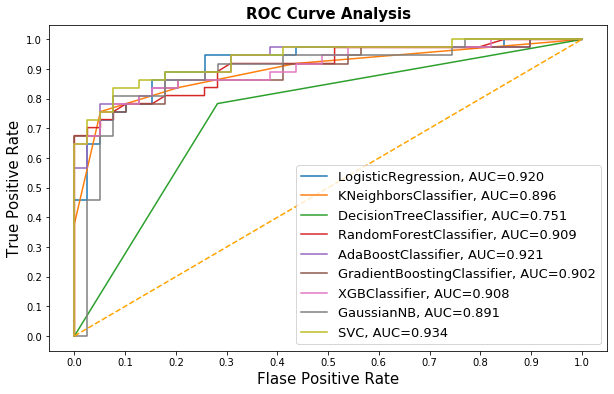

In [65]:
roc_mult_models(X_train, y_train, X_test, y_test, classifiers)

We can now repeat our process with tuning our models for better recall. 

## Conclusion

We see that using SMOTE makes our model better, we can see the AUC is much higher for our models. My assumption is that the accuracy and recall scores would be much better as well. 